# HDBSCAN Clustering for RBD sequences - Omicron Only

Take a look at the clusters and the pango lineages in them (above).
- Cluster %: The percentage of a specific Pango lineage within a particular cluster, calculated as the number of occurrences of that lineage in the cluster divided by the total number of occurrences of all lineages in the cluster.
- Lineage %: The percentage of a specific Pango lineage's occurrences in a cluster relative to its total occurrences across the entire dataset.

Maybe better names would be Lineage Cluster %, Lineage Dataset %?

---
### Omicron only (all available) - From finetuned esm-mlm

In [1]:
import os
import pandas as pd

data_dir = "../../data/rbd"
parquet_file = os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_from-esm-mlm_CLS-embedded.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')

# Extract Omicron only
embedded_o_df = embedded_ado_df[embedded_ado_df['variant'].isin(["Omicron"])]
print(embedded_o_df['variant'].value_counts())

save_as = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_from-esm-mlm_CLS-embedded.parquet")
embedded_o_df.to_parquet(save_as, index=False)

variant
Omicron    160016
Name: count, dtype: int64


Apply tSNE to the embeddings.

In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

# Load in the data
parquet_file = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_from-esm-mlm_CLS-embedded.parquet")
embedded_o_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix = np.vstack(embedded_o_df["embedding"])
info_df = embedded_o_df.drop(columns=["embedding"])

# Apply tSNE to reduce the dimensionality of the embedding matrix
perplexity = round(len(info_df) * 0.01)
print(perplexity) 
tsne_reducer = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', random_state=0)
embedding_matrix_reduced = tsne_reducer.fit_transform(embedding_matrix)

# Save the embedding
embeddings_df = pd.DataFrame(embedding_matrix_reduced, columns=['DIM_1', 'DIM_2']).reset_index(drop=True)
tsne_df = pd.concat([info_df, embeddings_df], axis=1)
save_as = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_from-esm-mlm_CLS-embedded.sampled.tsne-perp{perplexity}.parquet")
tsne_df.to_parquet(save_as, engine='fastparquet')

1600


Took ~ 46 minutes ^

Load in the tSNE embeddings.

In [7]:
import os
import pandas as pd

# Load the embedding
perplexity = 1600
data_dir = "../../data/rbd"
parquet_file = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_from-esm-mlm_CLS-embedded.sampled.tsne-perp{perplexity}.parquet")
embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix_reduced = embedded_df[['DIM_1', 'DIM_2']].values
info_df = embedded_df.drop(columns=['DIM_1', 'DIM_2'])

Find the highest Silhouette Coefficient (Adjusted Rand Index will be 0, since it is all Omicron).

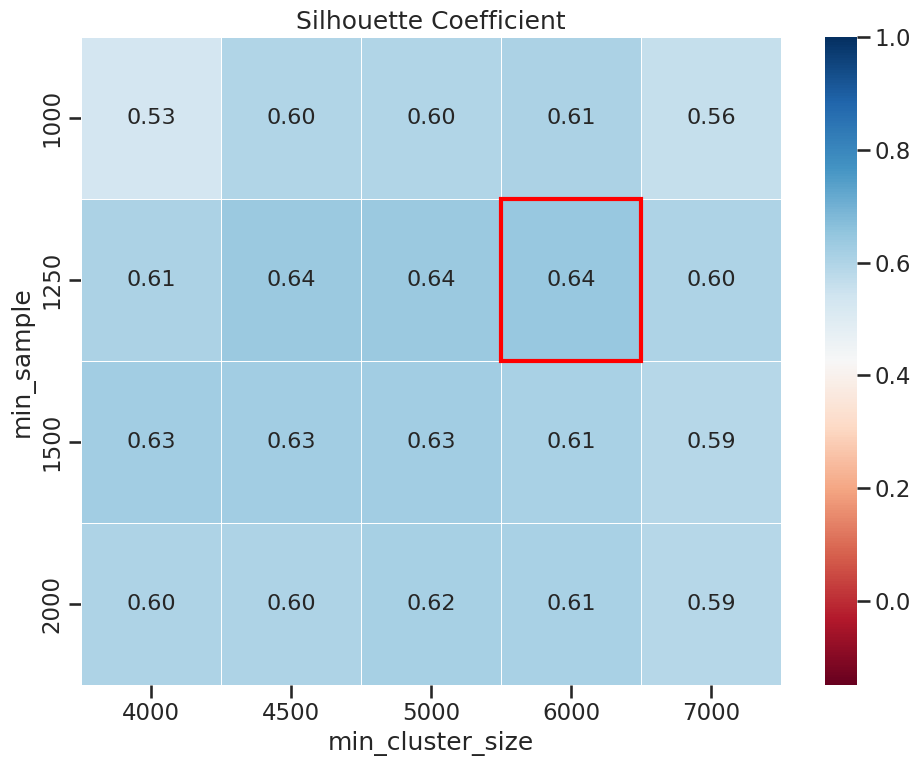

In [8]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def ari_sc_heatmap(embedding_matrix_reduced, info_df, save_as):
    results = []

    for ms in [1000, 1250, 1500, 2000]:
        for mcs in [4000, 4500, 5000, 6000, 7000]:
            # Cluster
            clusterer = hdbscan.HDBSCAN(
                min_samples=ms,
                min_cluster_size=mcs,
                core_dist_n_jobs=-1
            ).fit(embedding_matrix_reduced)

            labels = clusterer.labels_

            # Check number of clusters (excluding noise)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

            if n_clusters > 1:
                silhouette_avg = silhouette_score(embedding_matrix_reduced, labels)
            else:
                silhouette_avg = np.nan  # or 0, depending on how you want to treat it

            # Store results
            results.append({
                "min_sample": ms,
                "min_cluster_size": mcs,
                "silhouette": silhouette_avg
            })

    # Convert to DataFrame
    df = pd.DataFrame(results)

    # Pivot matrices
    silhouette_matrix = df.pivot(index='min_sample', columns='min_cluster_size', values='silhouette')

    # Plot heatmaps
    sns.set_style('ticks')
    sns.set_context("talk")
    fig, ax = plt.subplots(figsize=(10, 8))

    sns.heatmap(silhouette_matrix, annot=True, annot_kws={"size": 16}, fmt=".2f", linewidth=.5, cmap="RdBu", vmin=-0.15, vmax=1)
    ax.set_title("Silhouette Coefficient")
    ax.set_xlabel("min_cluster_size")
    ax.set_ylabel("min_sample")

    max_sc = silhouette_matrix.max().max()  # Get the max SC value

    for i in range(silhouette_matrix.shape[0]):  # min_sample (rows)
        for j in range(silhouette_matrix.shape[1]):  # min_cluster_size (cols)
            if np.isclose(silhouette_matrix.iloc[i, j], max_sc):  # Safe float comparison
                ax.add_patch(
                    plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='red', lw=3)
                )

    plt.tight_layout()
    plt.show()

save_as = f"RBD.O.from-esm-mlm.tSNE-perp{perplexity}.HDBSCAN_heatmap"
ari_sc_heatmap(embedding_matrix_reduced, info_df, save_as)

Plotting the tSNE embeddings after applying HDBSCAN.

/data/spike_ml/.venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/data/spike_ml/.venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_sample 1250, min_cluster_size 6000: Silhouette Coefficient: 0.64


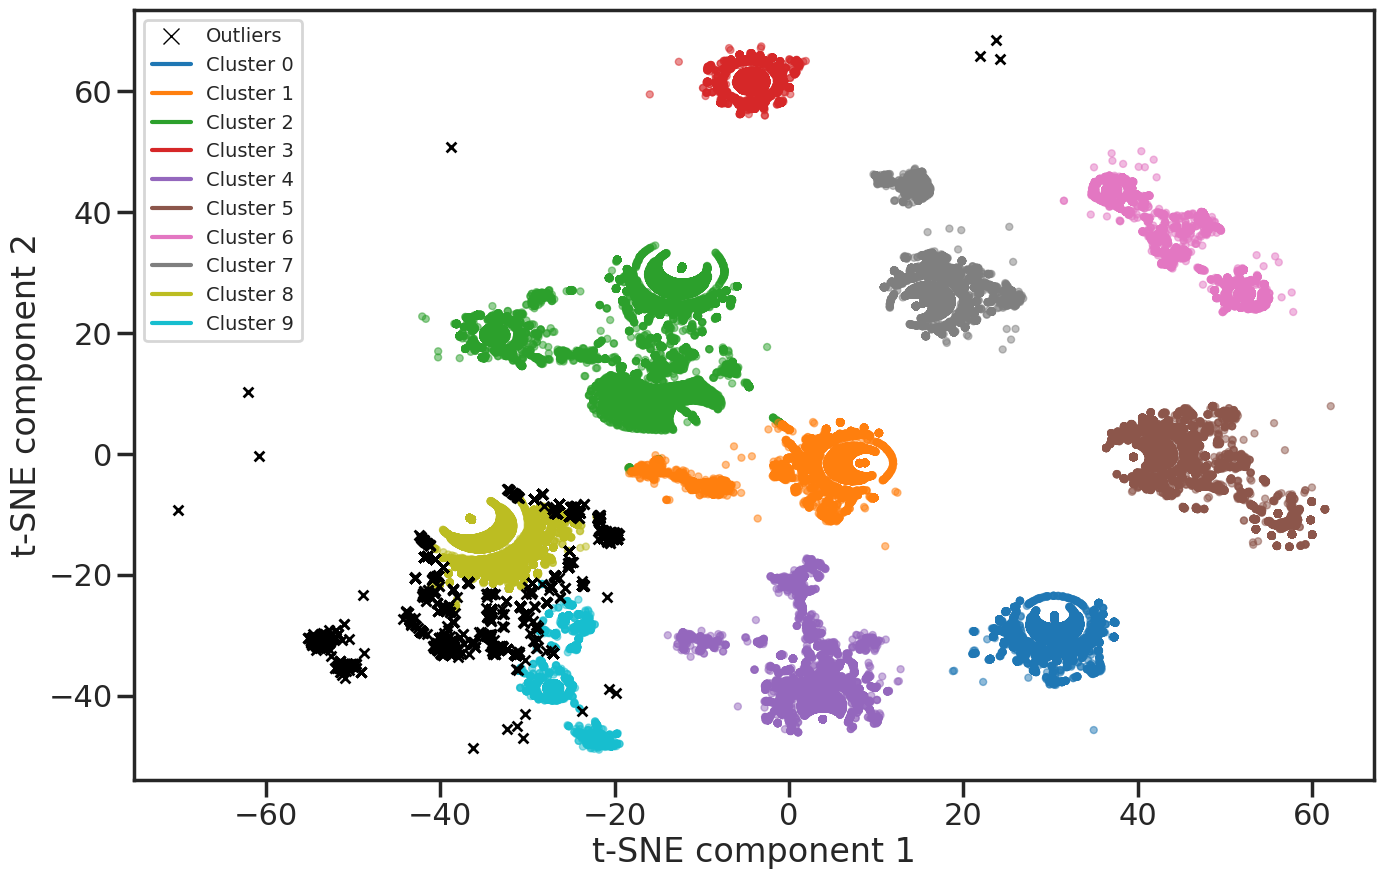

Predicted Clusters,-1,0,1,2,3,4,5,6,7,8,9
Ground Truth,,,,,,,,,,,
Omicron,5.06,7.56,9.44,17.47,4.3,10.76,9.71,6.99,8.79,15.7,4.23


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hdbscan
from sklearn.metrics import silhouette_score, adjusted_rand_score

def plot_prediction(embedding_matrix, info_df, hdb_labels, save_as, x_min_width_buffer=2, colormap="colorblind"):
    # Create a DataFrame for easier plotting
    plot_df = pd.DataFrame({
        't-SNE component 1': embedding_matrix[:, 0],
        't-SNE component 2': embedding_matrix[:, 1],
        'Cluster': hdb_labels,
        'Seq ID': info_df['seq_id'],
        'Variant': info_df['variant'],
    })
    marker_size = 25

    # Define a cluster color palette
    unique_clusters = np.unique(plot_df['Cluster'])
    cluster_color_palette = sns.color_palette(colormap, n_colors=len(unique_clusters)) 
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_color_palette)}
    cluster_color_dict[-1] = 'black'  # Set outliers to x

    sns.set_style('ticks')
    sns.set_context("poster")
    fig, ax = plt.subplots(figsize=(16, 10))

    #####################################################

    # Scatterplot for non-outliers
    sns.scatterplot(
        data=plot_df[plot_df['Cluster'] != -1],  # Exclude outliers
        x='t-SNE component 1', y='t-SNE component 2',
        hue='Cluster', palette=cluster_color_dict, 
        s=marker_size, alpha=0.5, edgecolor=None, linewidth=1,
    )

    # Scatterplot for outliers (Cluster = -1)
    sns.scatterplot(
        data=plot_df[plot_df['Cluster'] == -1],  # Select only outliers
        x='t-SNE component 1', y='t-SNE component 2',
        marker='x',
        s=marker_size*2, color='black', linewidth=2,
    )

    #ax.set_title(f"Predicted ({len(unique_clusters[unique_clusters != -1])} clusters)", ha='center', fontweight='bold')
    ax.set_xlim((plot_df['t-SNE component 1'].min()-x_min_width_buffer, plot_df['t-SNE component 1'].max()+5))
    ax.set_ylim(plot_df['t-SNE component 2'].min()-5, plot_df['t-SNE component 2'].max()+5),

    # Legend 
    cluster_handles = [plt.Line2D([0], [0], marker='x', color='black', linestyle='none', label='Outliers')]
    cluster_handles += [
        plt.Line2D([0], [0], color=cluster_color_dict[cluster], label=f'Cluster {cluster}')
        for cluster in unique_clusters if cluster != -1
    ]
    ax.legend(handles=cluster_handles)
    sns.move_legend(ax, "upper left", fontsize=14)

    #####################################################
  
    plt.savefig(f"{save_as}.pdf", format="pdf", dpi=300, bbox_inches='tight')
    plt.savefig(f"{save_as}.png", format="png", dpi=300, bbox_inches='tight')
    plt.show()

min_samples=1250
min_cluster_size=6000

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}")
save_as = f"RBD.O.from-esm-mlm.tSNE-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg:.2f}"

# Call the function
plot_prediction(embedding_matrix_reduced, info_df, hdb_labels, save_as, x_min_width_buffer=5, colormap="tab10")

# Create the truth table
truth_table_percent = pd.crosstab(info_df["variant"], hdb_labels, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'],
                                normalize='index')  # Normalize along the index (rows)
truth_table_percent = (truth_table_percent * 100).round(2)
truth_table_percent

   Cluster  variant Pango lineage  Cluster %  Lineage %
0       -1  Omicron       BA.5.2*  29.125974  14.792491
1       -1  Omicron       BA.5.1*  10.322660  10.937909
2       -1  Omicron         BF.14   4.091977  98.805970
3       -1  Omicron    Unassigned   3.894177   4.882964
4       -1  Omicron       BA.5.5*   3.646928  13.882353

   Cluster  variant Pango lineage  Cluster %  Lineage %
0        0  Omicron       BQ.1.1*  83.334711  93.092622
1        0  Omicron    Unassigned   3.604199   6.758642
2        0  Omicron      BQ.1.18*   1.967430  94.071146
3        0  Omicron      BQ.1.25*   1.033314  81.168831
4        0  Omicron          DU.1   0.876250  96.363636

   Cluster  variant Pango lineage  Cluster %  Lineage %
0        1  Omicron          BA.1  31.292202  88.388182
1        1  Omicron      BA.1.17*  21.759566  96.449531
2        1  Omicron      BA.1.15*  19.958957  96.727623
3        1  Omicron          BA.2   4.541242   4.923563
4        1  Omicron      BA.1.18*   4.369125  

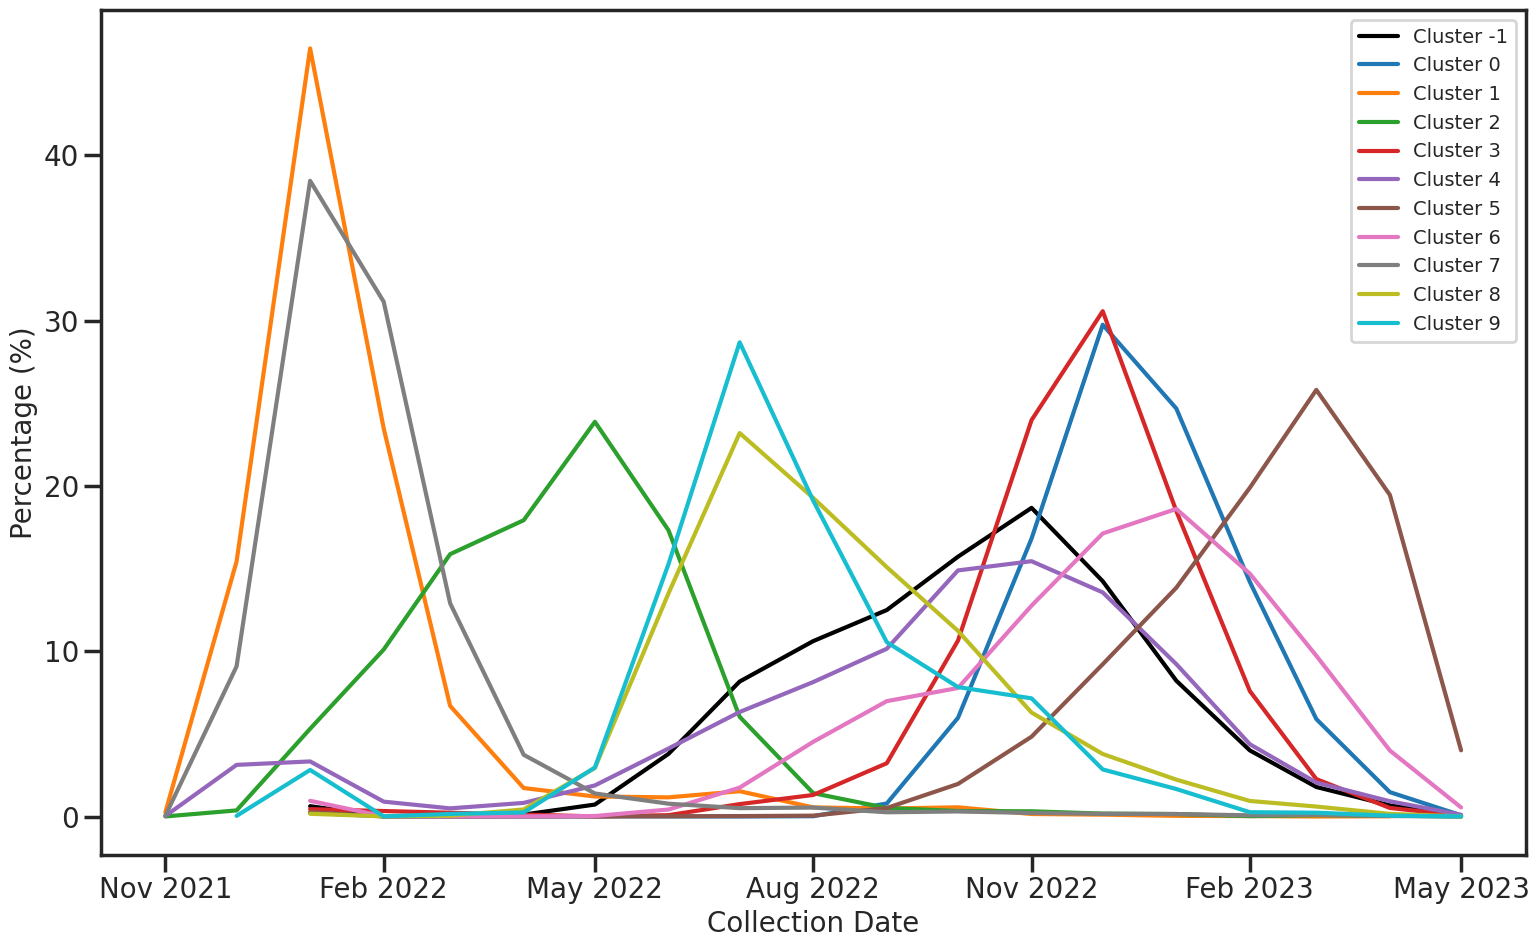

In [4]:
import matplotlib.dates as mdates

def cluster_date_collected(save_as, info_df, hdb_labels, colormap):
    """ Calculate variant percentages over collection dates within clusters and plot them in a single plot. """
    
    # Copy the DataFrame to avoid modifying the original
    df = info_df.copy()

    # Define cluster color mapping, with outliers (Cluster -1) as black
    unique_clusters = np.unique(hdb_labels)
    cluster_colors = sns.color_palette(colormap, n_colors=len(unique_clusters)-1)  # -1 to exclude outliers
    if len(sns.color_palette(colormap)) < (len(unique_clusters)-1):
        cluster_colors = sns.color_palette(colormap) + sns.color_palette(["#999933", "#882255", "#661100", "#6699CC", "#332288"])
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_colors)}
    cluster_color_dict[-1] = 'black'  # Outliers are gray

    # Ensure 'Collection date' is a datetime object
    df['Collection date'] = pd.to_datetime(df['Collection date'], format='mixed')

    # Aggregate data by counting variants for each collection date (by year and month)
    df['YearMonth'] = df['Collection date'].dt.to_period('M')
    cluster_date_counts = df.groupby(['Cluster', 'YearMonth', 'variant']).size().reset_index(name='Cluster count')

    # Calculate total count within each cluster
    total_cluster_count = df.groupby(['Cluster']).size().reset_index(name='Total count')
    cluster_date_counts = cluster_date_counts.merge(total_cluster_count, on='Cluster')

    # Calculate percentages within each cluster
    cluster_date_counts['Cluster %'] = (cluster_date_counts['Cluster count'] / cluster_date_counts['Total count']) * 100

    # Sort by 'Cluster' and 'YearMonth'
    cluster_date_counts = cluster_date_counts.sort_values(by=['Cluster', 'YearMonth'], ascending=[True, True])

    # Create a single plot with all clusters and variants
    sns.set_style('ticks')
    sns.set_context("poster")
    fig, ax = plt.subplots(figsize=(16, 10))

    # Plot each cluster-variant pair in the same plot, applying color mapping
    for (cluster_label, variant), grouped_df in cluster_date_counts.groupby(['Cluster', 'variant']):
        ax.plot(grouped_df['YearMonth'].dt.to_timestamp(), 
                grouped_df['Cluster %'], 
                label=f"Cluster {cluster_label}",
                color=cluster_color_dict[cluster_label],  # Apply cluster-specific color
                linewidth=3)

    fontsize = 20
    ax.set_xlabel('Collection Date', fontsize=fontsize)
    ax.set_ylabel(f'Percentage (%)', fontsize=fontsize)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.legend(loc='upper right', fontsize=fontsize-6, bbox_to_anchor=(1, 1))

    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(save_as + ".timescale.pdf", format="pdf")
    plt.savefig(save_as + ".timescale.png", format="png")
    plt.show()

def cluster_pango_lineage(info_df, top_x=None):
    """ Calculate Pango lineage percentages within clusters and select top x for each cluster. """
    
    # Copy the DataFrame to avoid modifying the original
    df = info_df.copy()

    # Truncate Pango lineage to the first two parts if needed
    trunc_format = lambda x: f"{'.'.join(x.split('.')[:3])}*" if len(x.split('.')) >= 3 else x
    df['Pango lineage'] = df['Pango lineage'].apply(trunc_format)

    # Calculate lineage counts within each cluster
    cluster_counts = df.groupby(['Cluster', 'variant', 'Pango lineage']).size().reset_index(name='Cluster count')

    # Calculate total counts for each lineage across the entire dataset
    total_counts = df.groupby('Pango lineage').size().reset_index(name='Total count')

    # Merge the cluster counts with total counts
    lineage_counts = pd.merge(cluster_counts, total_counts, on='Pango lineage', how='left')

    # Calculate the 'Cluster %' and 'Lineage %'
    lineage_counts['Cluster %'] = (lineage_counts['Cluster count'] / lineage_counts.groupby('Cluster')['Cluster count'].transform('sum')) * 100
    lineage_counts['Lineage %'] = (lineage_counts['Cluster count'] / lineage_counts['Total count']) * 100

    # Sort by 'cluster' and then by 'Cluster %' within each cluster
    lineage_counts = lineage_counts.sort_values(by=['Cluster', 'Cluster %'], ascending=[True, False])
    lineage_counts = lineage_counts.drop(columns=['Cluster count', 'Total count'])

    # Select top x lineages for each cluster
    if top_x != None:
        top_lineages_per_cluster = lineage_counts.groupby('Cluster').head(top_x)
        return top_lineages_per_cluster.reset_index(drop=True)
    else:
        return lineage_counts.reset_index(drop=True)

def split_dataframe_by_cluster(df):
    """ Split the DataFrame into separate DataFrames by cluster. """
    
    # Create a dictionary to store DataFrames for each cluster
    cluster_dfs = {}
    
    # Group the DataFrame by 'cluster' and iterate over each group
    for cluster, group in df.groupby('Cluster'):
        # Store each group as a separate DataFrame in the dictionary
        cluster_dfs[cluster] = group.reset_index(drop=True)
    
    return cluster_dfs

# Cluster info
info_df['Cluster'] = hdb_labels
result = cluster_pango_lineage(info_df, 5)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

cluster_date_collected(save_as, info_df, hdb_labels, "tab10")

---
### Omicron only (all available)

In [7]:
import os
import pandas as pd

data_dir = "../../data/rbd"
parquet_file = os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')

# Extract Omicron only
embedded_o_df = embedded_ado_df[embedded_ado_df['variant'].isin(["Omicron"])]
print(embedded_o_df['variant'].value_counts())

save_as = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_CLS-embedded.parquet")
embedded_o_df.to_parquet(save_as, index=False)

variant
Omicron    160016
Name: count, dtype: int64


In [8]:
import os
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

# Load in the data
parquet_file = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_CLS-embedded.parquet")
embedded_o_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix = np.vstack(embedded_o_df["embedding"])
info_df = embedded_o_df.drop(columns=["embedding"])

# Apply tSNE to reduce the dimensionality of the embedding matrix
perplexity = round(len(info_df) * 0.01)
print(perplexity) 
tsne_reducer = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', random_state=0)
embedding_matrix_reduced = tsne_reducer.fit_transform(embedding_matrix)

# Save the embedding
embeddings_df = pd.DataFrame(embedding_matrix_reduced, columns=['DIM_1', 'DIM_2']).reset_index(drop=True)
tsne_df = pd.concat([info_df, embeddings_df], axis=1)
save_as = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_CLS-embedded.sampled.tsne-perp{perplexity}.parquet")
tsne_df.to_parquet(save_as, engine='fastparquet')

1600


In [9]:
import os
import pandas as pd

# Load the embedding
perplexity = 1600
parquet_file = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_CLS-embedded.sampled.tsne-perp{perplexity}.parquet")
embedded_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix_reduced = embedded_df[['DIM_1', 'DIM_2']].values
info_df = embedded_df.drop(columns=['DIM_1', 'DIM_2'])

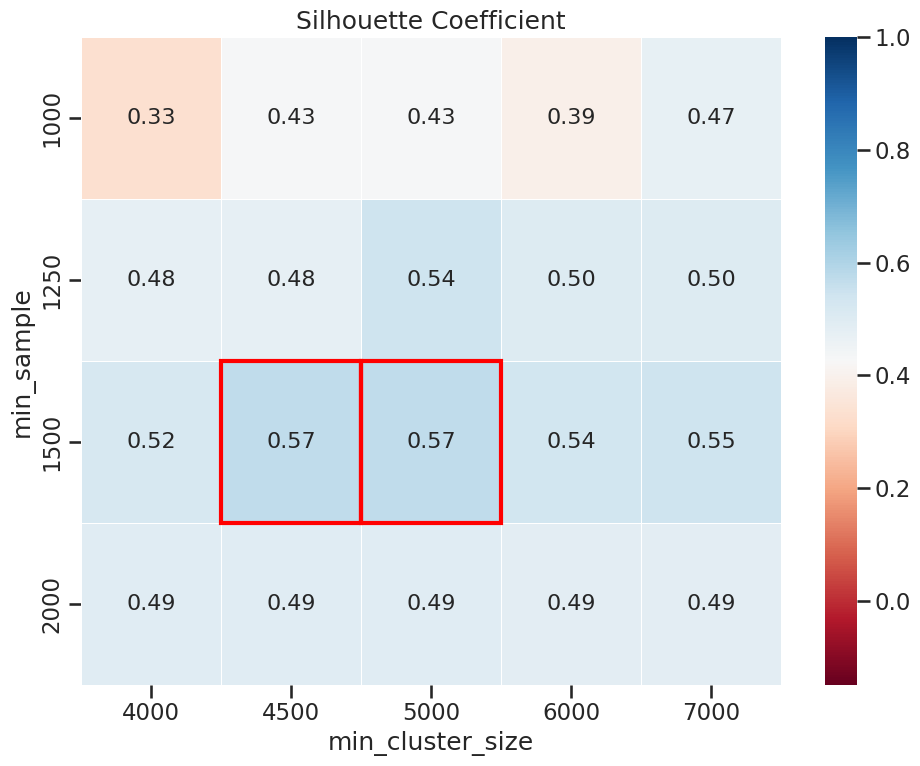

In [10]:
save_as = f"RBD.O.tSNE-perp{perplexity}.HDBSCAN_heatmap"
ari_sc_heatmap(embedding_matrix_reduced, info_df, save_as)

/data/spike_ml/.venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/data/spike_ml/.venv/lib64/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


min_sample 1500, min_cluster_size 4500: Silhouette Coefficient: 0.57


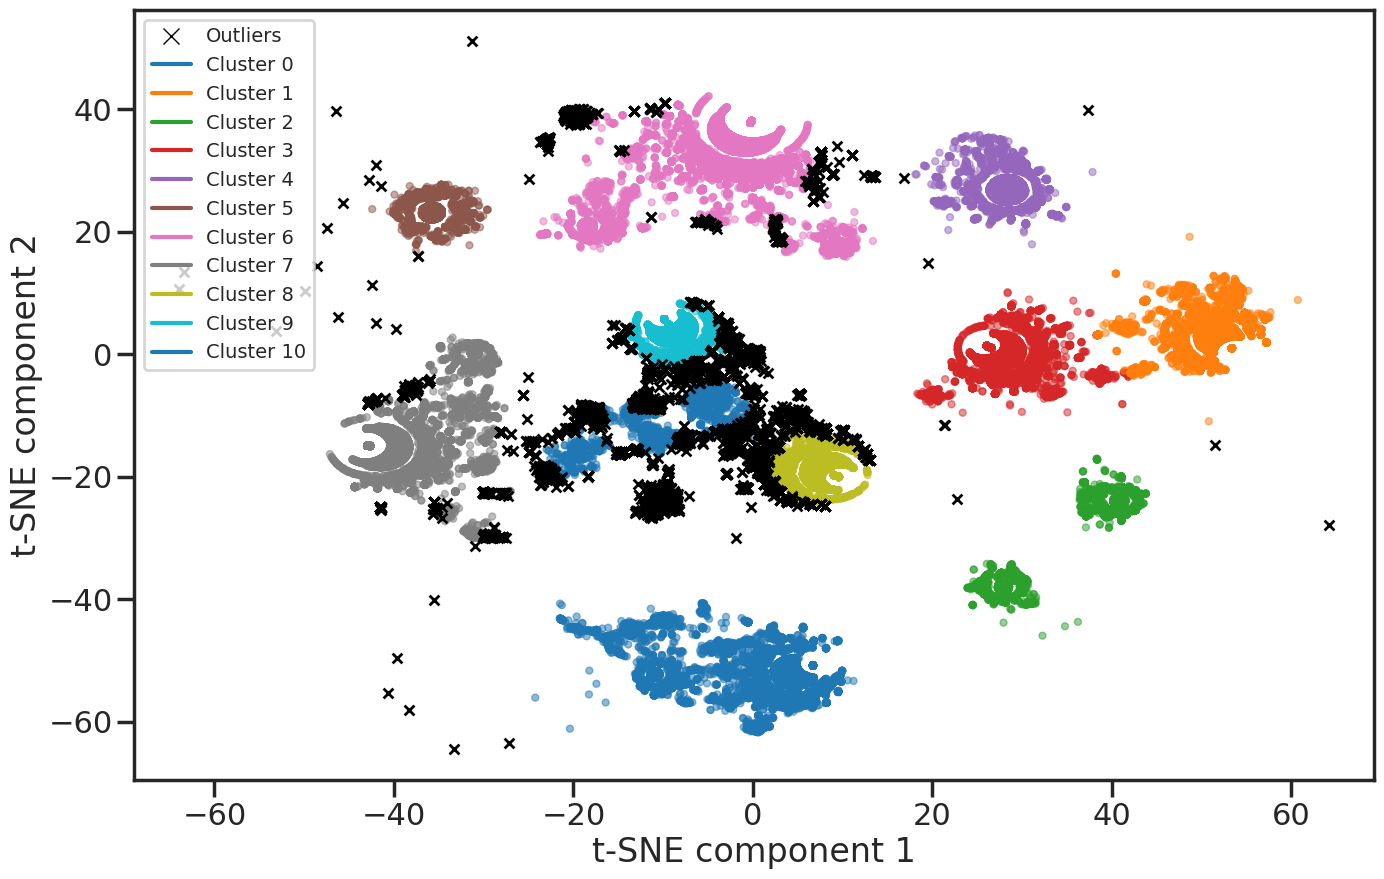

Predicted Clusters,-1,0,1,2,3,4,5,6,7,8,9,10
Ground Truth,,,,,,,,,,,,
Omicron,8.32,11.93,7.66,4.91,8.13,5.23,3.29,21.42,13.84,5.9,5.31,4.06


In [6]:
min_samples=1500
min_cluster_size=4500

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}")
save_as = f"RBD.O.tSNE-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg:.2f}"

# Call the function
plot_prediction(embedding_matrix_reduced, info_df, hdb_labels, save_as, x_min_width_buffer=5, colormap="tab10")

# Create the truth table
truth_table_percent = pd.crosstab(info_df["variant"], hdb_labels, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'],
                                normalize='index')  # Normalize along the index (rows)
truth_table_percent = (truth_table_percent * 100).round(2)
truth_table_percent

   Cluster  variant Pango lineage  Cluster %  Lineage %
0       -1  Omicron       BA.1.1*  20.389152  20.889778
1       -1  Omicron          BA.2  11.216287  10.715567
2       -1  Omicron          BA.1  10.465029  26.047120
3       -1  Omicron       BA.5.2*   7.302231   6.102844
4       -1  Omicron    Unassigned   6.107730  12.602697

   Cluster  variant Pango lineage  Cluster %  Lineage %
0        0  Omicron      XBB.1.5*  42.534577  99.460982
1        0  Omicron         XBB.1   6.166178  99.324895
2        0  Omicron      XBB.1.9*   5.658005  98.991751
3        0  Omicron      BA.2.75*   5.196982  78.357030
4        0  Omicron     XBB.1.16*   3.730092  99.441341

   Cluster  variant Pango lineage  Cluster %  Lineage %
0        1  Omicron       BA.4.6*  16.008486  92.459943
1        1  Omicron       BA.5.2*  14.099217  10.849501
2        1  Omicron          BF.7  13.332245  94.724638
3        1  Omicron      BF.7.14*   5.270888  97.730711
4        1  Omicron       BA.5.1*   4.756854  

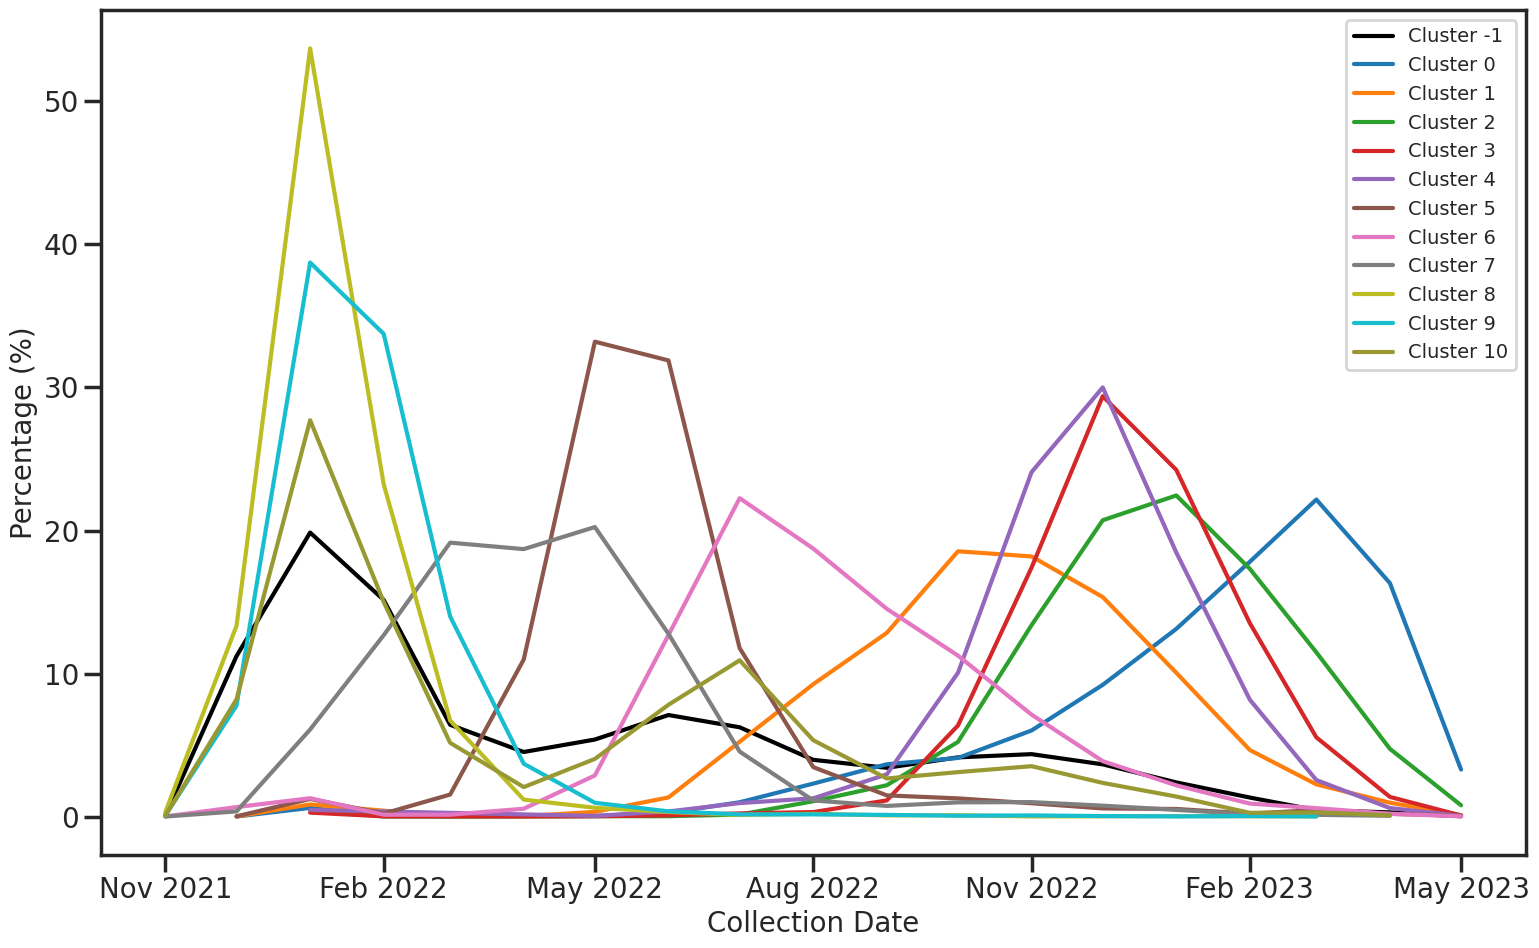

In [7]:
# Cluster info
info_df['Cluster'] = hdb_labels
result = cluster_pango_lineage(info_df, 5)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

cluster_date_collected(save_as, info_df, hdb_labels, "tab10")